# Imports

In [1]:
#Array imports
import numpy as np 
import pandas as pd 

#Graph plots imports
%matplotlib inline
import geopandas
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import geopandas
from mpl_toolkits.basemap import Basemap
import csv
import sklearn.linear_model

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
np.random.seed(42)

# Imports
import os
import tarfile 
from six.moves import urllib

In [3]:
#ML imports
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Explore Data

Data sources: 
    1. Boreholes - USGS Groundwater Mapping datasets 
    
    2. Altitude - NASA Earth Observation Data (Digital Elevation Models)
    
    3. Soil type - Africa Soil Information Service
    https://www.isric.org/explore/soilgrids
    
    4. Lithography - SERVIR/NASA Africa Surface Lithology Survey
    http://opendata.rcmrd.org/datasets/africa-surface-lithology/data
    
    5. Proximity data to lake and rivers calculated using vector distance tools
    https://docs.qgis.org/testing/en/docs/user_manual/processing_algs/qgis/vectoranalysis.html#qgisdistancetonearesthubpoints

In [4]:
#Load Turkana Training Dataset
turkanaBH = pd.read_csv("C:/Users/NATHANWANGUSI/Box Sync/Water/Research/DSS/Groundwater/Data/turkanaData/groundwaterClassifierInputs/csv/trainingSet_gw.csv")


In [5]:
#Load Turkana Test Dataset

turkanaBH_test = pd.read_csv("C:/Users/NATHANWANGUSI/Box Sync/Water/Research/DSS/Groundwater/Data/turkanaData/groundwaterClassifierInputs/csv/testSet_gw.csv")

In [6]:
turkanaBH['DEPTH_CLASS'] = pd.cut(turkanaBH['DEPTH'], 
                                  bins=[0,30,40,60,80,100,120,140,float('Inf')], 
                                  labels=['0-30','30-40','41-60','61-80','81-100','101-120','121-140','140+'])

In [7]:
turkanaBH.head()

,BOREHOLE_ID,BOREHOLE_NAME,DEPTH_CLASS,DEPTH,LAT,LONG,ALT,SOIL_TYPE,LITH_CODE,LAKE_PROX,RIVER_PROX
0,1,Unamed 6,30-40,30.5,3.3194,35.9644,604,CMca,19,0.201857,20.864685
1,2,Unamed 7,0-30,30.0,3.3194,35.9583,622,CMca,19,0.237385,20.697343
2,3,Unamed 2,0-30,30.0,3.3142,35.9589,565,CMca,14,0.600869,20.154360
3,4,Unamed 8,0-30,30.0,3.3194,35.9525,761,CMca,10,0.720092,20.557714
4,5,Unamed 3,30-40,30.5,3.3142,35.9667,607,CMca,9,0.788452,20.380654


In [8]:
turkanaBH_test.head()

,BOREHOLE_ID,BOREHOLE_NAME,LAT,LONG,ALT,SOIL_TYPE,LITH_CODE,LAKE_PROX,RIVER_PROX
0,272,Lotonguna,2.472500,35.504028,760,RGca,10,88.024674,12.648236
1,273,Kaichupaluk,2.535528,35.579694,812,RGca,10,77.099128,22.076143
2,274,Kalokoda,2.397806,35.506583,746,RGca,10,93.228497,11.182644
3,275,Kagete,2.293306,35.489917,743,RGca,10,102.716447,8.784197
4,276,Kachila,2.218083,35.499611,763,ARbr,10,108.211224,10.299680


In [9]:
turkanaBH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 11 columns):
BOREHOLE_ID      271 non-null int64
BOREHOLE_NAME    271 non-null object
DEPTH_CLASS      271 non-null category
DEPTH            271 non-null float64
LAT              271 non-null float64
LONG             271 non-null float64
ALT              271 non-null int64
SOIL_TYPE        271 non-null object
LITH_CODE        271 non-null int64
LAKE_PROX        271 non-null float64
RIVER_PROX       271 non-null float64
dtypes: category(1), float64(5), int64(3), object(2)
memory usage: 21.9+ KB


In [10]:
turkanaBH.describe()

,BOREHOLE_ID,DEPTH,LAT,LONG,ALT,LITH_CODE,LAKE_PROX,RIVER_PROX
count,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000
mean,136.000000,62.998339,3.500880,35.324236,644.605166,11.730627,78.863793,87.937928
std,78.375166,36.437408,0.813125,0.521010,173.352379,2.824061,47.481881,62.269425
min,1.000000,6.000000,1.336400,34.233300,347.000000,6.000000,0.201857,0.382124
25%,68.500000,32.000000,2.983300,34.871100,521.000000,10.000000,43.672765,20.734086
50%,136.000000,60.000000,3.683300,35.442200,617.000000,10.000000,70.555346,98.135487
75%,203.500000,90.000000,4.169450,35.657600,725.000000,14.000000,109.037599,134.889934
max,271.000000,180.000000,5.040300,36.353900,1315.000000,19.000000,182.104180,209.698536


In [11]:
turkanaBH["DEPTH_CLASS"].value_counts()

0-30       63
41-60      62
61-80      44
81-100     39
30-40      27
101-120    14
140+       12
121-140    10
Name: DEPTH_CLASS, dtype: int64

In [12]:
turkanaBH["LITH_CODE"].value_counts()

10    107
14     94
9      50
19     17
7       2
6       1
Name: LITH_CODE, dtype: int64

In [13]:
turkanaBH["LITH_CODE"].value_counts()

10    107
14     94
9      50
19     17
7       2
6       1
Name: LITH_CODE, dtype: int64

In [14]:
turkanaBH["SOIL_TYPE"].value_counts()

RGca    57
FLeu    45
SNcc    34
PLeu    25
ARbr    23
CMca    21
FLca    17
SCcc    12
CMeu    11
SNmo    10
RGdy     4
CLlv     4
LPli     3
LXha     2
CLha     2
LVcr     1
Name: SOIL_TYPE, dtype: int64

In [15]:
turkanaBH["DEPTH_CLASS"].value_counts()

0-30       63
41-60      62
61-80      44
81-100     39
30-40      27
101-120    14
140+       12
121-140    10
Name: DEPTH_CLASS, dtype: int64

# Visualize


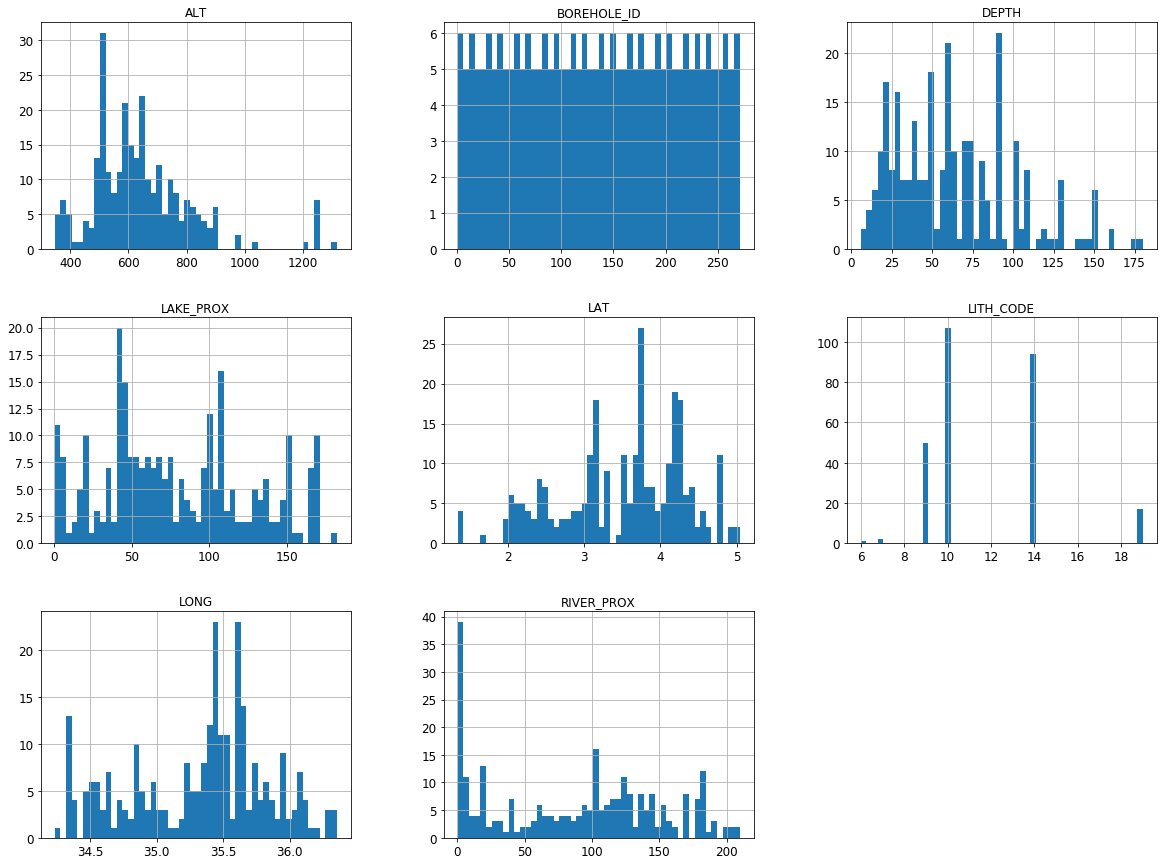

In [16]:
turkanaBH.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
turkanaBH["DEPTH"].hist()

In [ ]:
#Visualize data
turkanaBH.plot(kind ="scatter", x="LONG", y="LAT", alpha=0.9,
            s=turkanaBH["DEPTH"], label="LAKE_PROX", figsize=(30,27),
            c= "DEPTH", cmap=plt.get_cmap("jet"), colorbar=True,
            )
plt.legend()

In [ ]:


lats, lons,depth,altitude = [],[],[],[]

with open("C:/Users/NATHANWANGUSI/Box Sync/Water/Research/DSS/Groundwater/Data/turkanaData/groundwaterClassifierInputs/csv/trainingSet_gw.csv") as csvfile:
    reader = csv.DictReader(csvfile,delimiter=',')
    for data in reader:
        depth.append(float(data['DEPTH']))
        lats.append(float(data['LAT']))
        lons.append(float(data['LONG']))
        altitude.append(float(data['ALT']))
        
# How much to zoom from coordinates (in degrees)
zoom_scale = 0.2

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

fig, ax = plt.subplots(figsize=(20,17))
plt.title("Borehole Depths in Turkana")

# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',
            llcrnrlat=bbox[0],
            urcrnrlat=bbox[1],
            llcrnrlon=bbox[2],
            urcrnrlon=bbox[3],
            lat_ts=10,
            resolution='c')

#Use etopo tile as background
m.etopo()

# Draw coastlines and fill continents and water with color
m.drawcountries(linewidth=2)
m.drawrivers(linewidth=0.5, linestyle='dashed', color='#0000ff')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=15)
m.drawmapboundary()

# format colors for depth range
depth_min = np.min(depth)
depth_max = np.max(depth)
cmap = plt.get_cmap('gist_earth')
normalize = matplotlib.colors.Normalize(vmin=depth_min, vmax=depth_max)

# plot depths with different colors using the numpy interpolation mapping tool
# the range [10,200] can be changed to create different colors and ranges

for ii in range(0,len(depth)):
    x,y = m(lons[ii],lats[ii])
    color_interp = np.interp(depth[ii],[depth_min,depth_max],[10,600])
    plt.plot(x,y,0,marker='o', markersize=10, color=cmap(int(color_interp)))

# format the colorbar 
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,norm=normalize,label='Depth')

# Plot map
plt.show()


In [ ]:
from pandas.plotting import scatter_matrix

attributes =["DEPTH","ALT","LAT", "LONG","LAKE_PROX","LITH_CODE"]
scatter_matrix(turkanaBH[attributes], figsize=(12,8))

In [ ]:
turkanaBHdf = pd.DataFrame(turkanaBH)

In [ ]:

turkanaBHHist = turkanaBHdf.groupby(["LITH_CODE"]).DEPTH.plot(kind="hist", legend="True", bins = 12, alpha = 0.2,figsize=(12,8))
plt.xlabel('Depth')
plt.ylabel('Frequency')


In [ ]:
turkanaBH.groupby(['LITH_CODE']).DEPTH.mean()

# Transformation Pipeline


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [ ]:
#Imputer strategy for numerical attributes
from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["LAT","LONG","ALT","LAKE_PROX","RIVER_PROX"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [ ]:
num_pipeline.fit_transform(turkanaBH)

In [ ]:
# Imputer strategy for strings categorical columns
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

In [ ]:
#Pipeline for categorical attributes
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["SOIL_TYPE","LITH_CODE"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [ ]:
cat_pipeline.fit_transform(turkanaBH)

In [ ]:
#Join the numerical and categorical pipelines
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion (transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [ ]:
X_train=preprocess_pipeline.fit_transform(turkanaBH)
X_train

In [ ]:
#Label the target variable
y_train=turkanaBH["DEPTH_CLASS"]

In [ ]:
#Train the SVC classifier
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

In [ ]:
#Predict depth category using SVM
import numpy
X_test = preprocess_pipeline.transform(turkanaBH_test)
y_pred=svm_clf.predict(X_test)
print(y_pred)

In [ ]:
#Cross validation to check model performance
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

In [ ]:
#Train Random Forest Classifier: 
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_scores = cross_val_score(log_clf, X_train, y_train, cv=3, verbose=3)
log_scores.mean()

In [ ]:
 from sklearn.neighbors import KNeighborsClassifier 
clf =  KNeighborsClassifier(4)
kneigh_scores = cross_val_score(clf, X_train, y_train, cv=5)
kneigh_scores.mean()

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot([svm_scores, forest_scores, log_scores, kneigh_scores], 
            labels=("SVM","Random Forest","Log Regression", "K-Neighbor"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()